In [279]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
 
from sklearn.metrics import mean_squared_error, make_scorer
seed = np.random.seed(42)

## 1. Data Visualization

In [280]:
train = pd.read_csv('resources/train.csv')
test = pd.read_csv('resources/test.csv')

In [281]:
categorical_features = train.select_dtypes(include='object').columns.to_list()
numeric_features = train.select_dtypes(include='number').columns.to_list()[1:-1]
features = numeric_features + categorical_features

In [282]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), numeric_features),
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), categorical_features),
    ], 
    verbose=True,
    # remainder='passthrough'
)

In [283]:
train_transformed = preprocessor.fit_transform(train)
train_transformed = pd.DataFrame(train_transformed,columns=features)

[ColumnTransformer] ....... (1 of 2) Processing numeric, total=   0.0s
[ColumnTransformer] ... (2 of 2) Processing categorical, total=   0.0s


In [284]:
train_transformed.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.00000,...,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
5,0.176471,0.219178,0.059899,0.444444,0.500,0.876812,0.750000,0.00000,0.129695,0.00000,...,1.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
6,0.000000,0.184932,0.041057,0.777778,0.500,0.956522,0.916667,0.11625,0.242558,0.00000,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
7,0.235294,0.167979,0.042450,0.666667,0.625,0.731884,0.383333,0.15000,0.152197,0.02171,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
8,0.176471,0.102740,0.022529,0.666667,0.500,0.427536,0.000000,0.00000,0.000000,0.00000,...,5.0,2.0,1.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
9,1.000000,0.099315,0.028605,0.444444,0.625,0.485507,0.000000,0.00000,0.150780,0.00000,...,1.0,1.0,2.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0


In [285]:
train.iloc[:10, :20]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939


In [286]:
train.iloc[:10,20:40]

,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating
0,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA
1,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA
2,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA
3,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA
4,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA
5,1995,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA
6,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA
7,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA
8,1950,Gable,CompShg,BrkFace,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA
9,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA


In [287]:
train.iloc[:10,40:60]

,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt
0,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0
1,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0
2,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0
3,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0
4,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0
5,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0
6,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0
7,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0
8,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0
9,Ex,Y,SBrkr,1077,0,0,1077,1,0,1,0,2,2,TA,5,Typ,2,TA,Attchd,1939.0


In [288]:
train.iloc[:10,60:]

,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,RFn,2,548,TA,TA,Y,0,61,0,0,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,RFn,2,460,TA,TA,Y,298,0,0,0,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,RFn,2,608,TA,TA,Y,0,42,0,0,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,Unf,3,642,TA,TA,Y,0,35,272,0,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,RFn,3,836,TA,TA,Y,192,84,0,0,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,Unf,2,480,TA,TA,Y,40,30,0,320,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,RFn,2,636,TA,TA,Y,255,57,0,0,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,RFn,2,484,TA,TA,Y,235,204,228,0,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,Unf,2,468,Fa,TA,Y,90,0,205,0,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,RFn,1,205,Gd,TA,Y,0,4,0,0,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## 2. Data Preprocessing

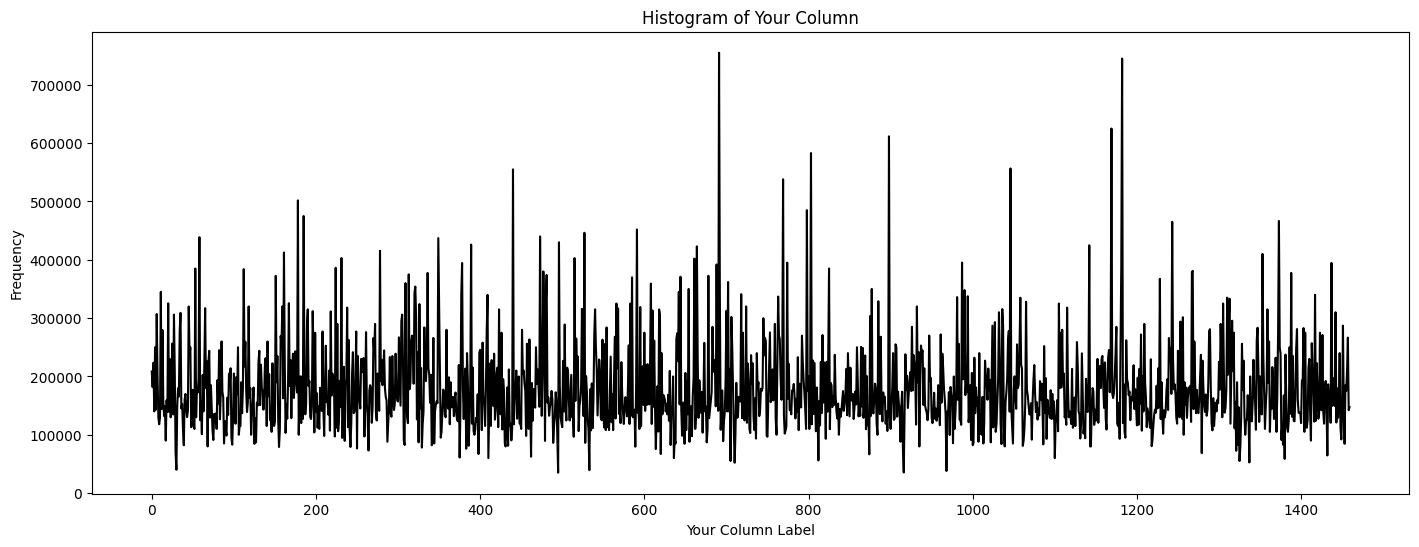

In [289]:
plt.figure(figsize=(17, 6))  
# plt.scatter(range(len(train.index)),train['LotArea'],color='r',s=5)
plt.plot(range(len(train.index)),train['SalePrice'],color='black')
plt.xlabel('Your Column Label')
plt.ylabel('Frequency')
plt.title('Histogram of Your Column')
plt.show()

In [290]:
train_transformed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,5.0,2.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,8.0,4.0


## 2.2 Corelation Analysis

In [291]:
correlation_matrix = train_transformed.corr()

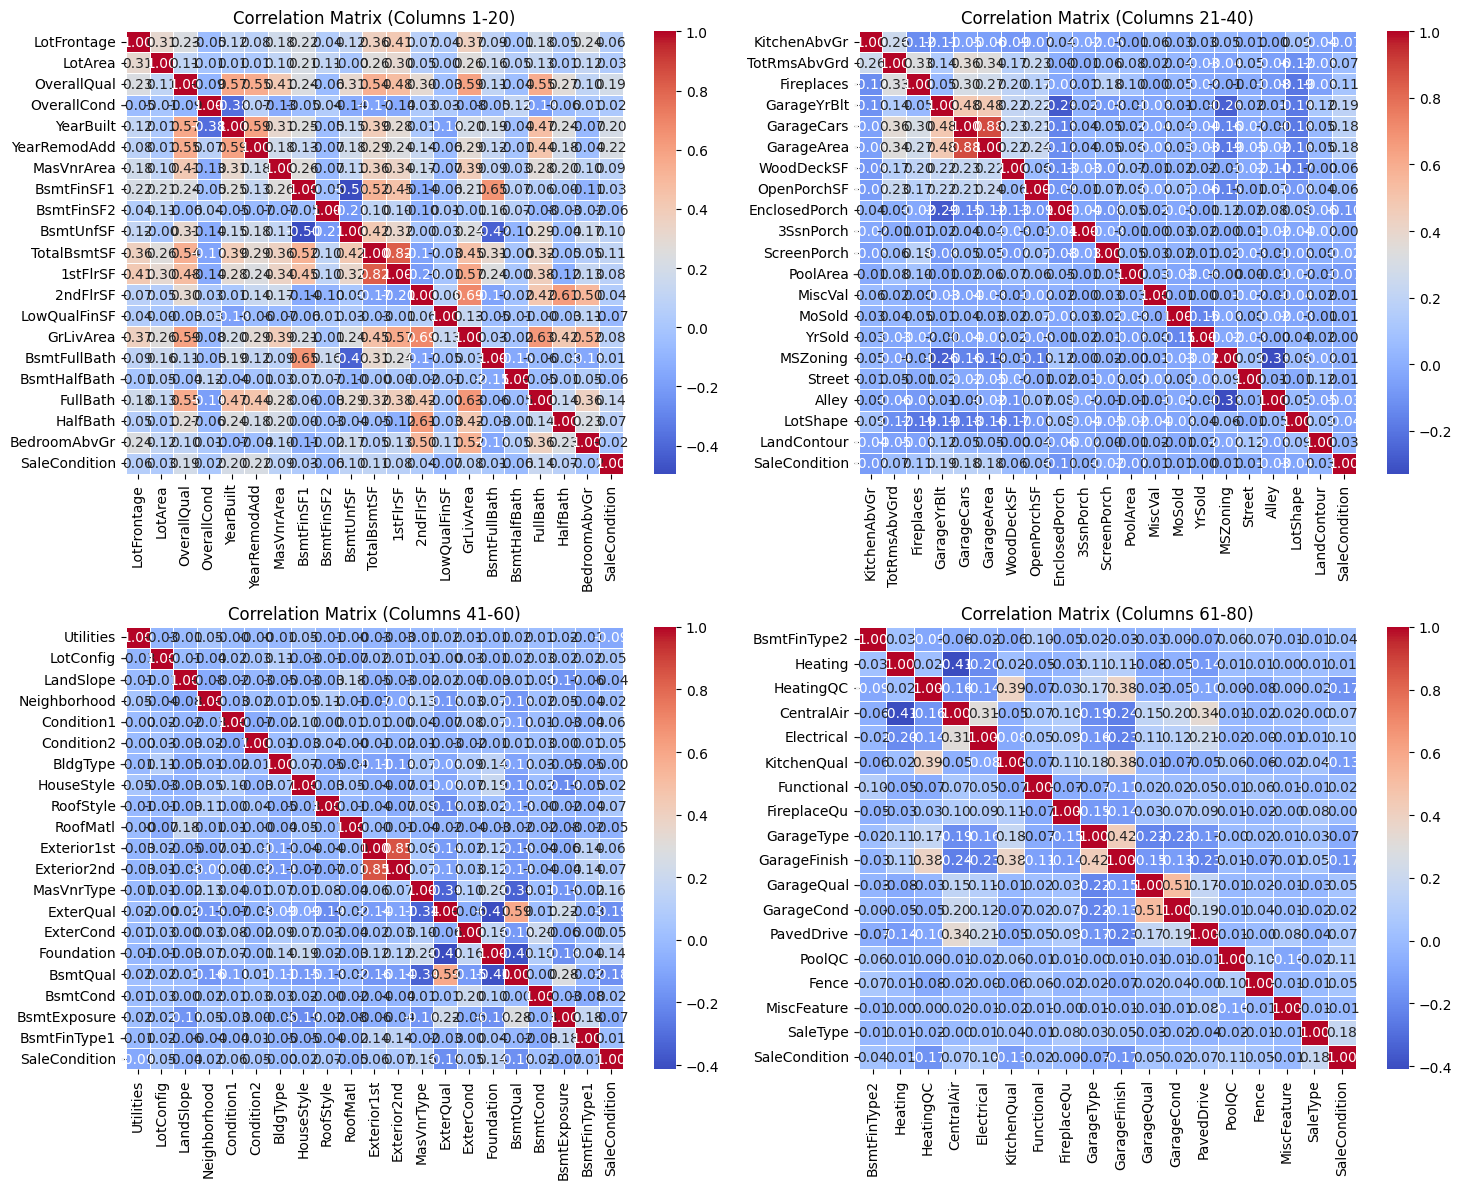

In [292]:

correlation_20 = train_transformed.columns[1:21].tolist() + [train_transformed.columns[-1]]
correlation_40 = train_transformed.columns[21:41].tolist() + [train_transformed.columns[-1]]
correlation_60 = train_transformed.columns[41:61].tolist() + [train_transformed.columns[-1]]
correlation_80 = train_transformed.columns[61:81].tolist()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

sns.heatmap(
    correlation_matrix.loc[correlation_20, correlation_20],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_20, yticklabels=correlation_20,
    ax=axes[0, 0]
)
axes[0, 0].set_title('Correlation Matrix (Columns 1-20)')

sns.heatmap(
    correlation_matrix.loc[correlation_40, correlation_40],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_40, yticklabels=correlation_40,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Correlation Matrix (Columns 21-40)')

sns.heatmap(
    correlation_matrix.loc[correlation_60, correlation_60],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_60, yticklabels=correlation_60,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Correlation Matrix (Columns 41-60)')

sns.heatmap(
    correlation_matrix.loc[correlation_80, correlation_80],
    annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
    xticklabels=correlation_80, yticklabels=correlation_80,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Correlation Matrix (Columns 61-80)')

plt.tight_layout()
plt.show()


## 2.3 Feature extraction

In [293]:
last_column_correlations = correlation_matrix.iloc[:-1, -1]
most_correlated_features = last_column_correlations.abs().sort_values(ascending=False).index

In [294]:
train.loc[:,most_correlated_features[:40]].head()

,YearRemodAdd,YearBuilt,OverallQual,GarageYrBlt,ExterQual,GarageCars,BsmtQual,SaleType,GarageArea,HeatingQC,...,TotRmsAbvGrd,GarageType,Exterior2nd,PoolArea,KitchenAbvGr,RoofStyle,Exterior1st,OpenPorchSF,BsmtHalfBath,BsmtFinSF2
0,2003,2003,7,2003.0,Gd,2,Gd,WD,548,Ex,...,8,Attchd,VinylSd,0,1,Gable,VinylSd,61,0,0
1,1976,1976,6,1976.0,TA,2,Gd,WD,460,Ex,...,6,Attchd,MetalSd,0,1,Gable,MetalSd,0,1,0
2,2002,2001,7,2001.0,Gd,2,Gd,WD,608,Ex,...,6,Attchd,VinylSd,0,1,Gable,VinylSd,42,0,0
3,1970,1915,7,1998.0,TA,3,TA,WD,642,Gd,...,7,Detchd,Wd Shng,0,1,Gable,Wd Sdng,35,0,0
4,2000,2000,8,2000.0,Gd,3,Gd,WD,836,Ex,...,9,Attchd,VinylSd,0,1,Gable,VinylSd,84,0,0


In [295]:
class TudisFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, features= None, features_no=1):
        self.features = features 
        self.features_no = features_no
       
    def fit(self, X,):
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X,columns=features)
        print(np.array(self.features).shape)
        print(self.features_no)
        correlated_features = self.features[:self.features_no]
        X = train_transformed.loc[:,correlated_features].to_numpy()
        print(X.shape)
        return X

In [296]:
pip = Pipeline([
    ('preprocessor',preprocessor),
    ('extractor',TudisFeatureExtractor(features=most_correlated_features,features_no=20)),
], 
verbose=True
)

X_train = pip.transform(train)

(78,)
20
(1460, 20)


In [297]:
X_train, X_val, y_train, y_val = train_test_split(X_train, train['SalePrice'].values, test_size=0.2, random_state=seed)

## 3. Model selection

In [298]:
models = {
    'SVR': SVR(),
    'Linear Regression': LinearRegression(),
    'AdaBoost': AdaBoostRegressor(random_state=seed),
}

param_grids = {
    'SVR': {
        'C': [0.1, 0.5, 1], 
        'kernel': ['poly'],
        'degree': [2, 3]
        },

    'Linear Regression': {
        # 'n_features_in_':[10,20]
    },        
    'AdaBoost': {
        'estimator' : [SVR()],
        # 'learning_rate': [0.2],
        'n_estimators':[50], 
    }
}

## 4. Training and Validation

In [299]:
best_models = {}
best_score = float('inf')
best_model = None 
rmse_scorer = make_scorer(lambda y_val, y_pred: np.sqrt(mean_squared_error(y_val, y_pred)), greater_is_better=False)

In [300]:

for model_name, model in models.items():
    param_grid = param_grids[model_name]

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=5,
        scoring=rmse_scorer,
        verbose=1
    )
    
    grid_search.fit(X_train,y_train)
    y_pred = grid_search.best_estimator_.predict(X_val)
    rmse_val = rmse_scorer(y_val, y_pred)

    best_models[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'rmse_val': rmse_val
    }

    print(f"[{model_name}] : {best_models[model_name]['best_params']}")
    print(f"[{model_name} VALIDATION RMSE] : {best_models[model_name]['rmse_val']}")
    print("=" * 100)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

In [ ]:
best_model.fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_val)

In [ ]:
rMSE = np.sqrt(mean_squared_error(y_val, y_pred))

print("[rMSE]:\t\t", rMSE)

## 4. Metrics

In [ ]:
plt.figure(figsize=(17, 6))

plt.scatter(y_val, y_pred, alpha=0.5, label='Predictions',color='black',s=3)
plt.xlabel('Real Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Values')

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='red', linewidth=2, label='Ideal Line')

plt.legend()
plt.show()

## Test

In [ ]:
X_test = preprocessor.transform(test)

In [ ]:
test_preds = pip.predict(X_test)

In [ ]:
plt.figure(figsize=(17, 6))
plt.plot(range(len(test_preds)), test_preds, alpha=0.5, label='SVR Predictions',color='black')
plt.show()